## NMF-PY Walkthrough

### Input Data Analysis

Input data statistics are provided in PMF5 after the user provides concentration and uncertainty data files.


In [1]:
# Python imports

import os
import sys
import copy
import logging
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data.datahandler import DataHandler
from src.model.base_nmf import BaseSearch
from tests.factor_comparison import FactorComp
from src.utils import calculate_Q

In [2]:
# PMF5 provided input data files
# PMF5 example input files for the Baton Rouge dataset

input_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-BatonRouge-con.csv")
uncertainty_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-BatonRouge-unc.csv")
output_path = os.path.join("D:\\", "projects", "nmf_py", "output", "BatonRouge")

In [3]:
# Load data files and calculate statistics
# Category is defaulted to 'Strong' and has not been integrated into the NMF workflow.

dh = DataHandler(
        input_path=input_file,
        uncertainty_path=uncertainty_file,
        output_path=output_path,
        index_col='Date'
    )
dh.metrics

01-Mar-23 14:16:18 - Input and output configured successfully


,Category,S/N,Min,25th,50th,75th,Max
124-Trimethylbenzene,Strong,5.445168,0.005000,0.820001,1.290001,1.865001,5.470003
224-Trimethylpentane,Strong,5.666667,0.410000,1.580001,2.490002,3.865002,13.560008
234-Trimethylpentane,Strong,5.537459,0.005000,0.530000,0.820001,1.300001,4.410003
23-Dimethylbutane,Strong,5.500543,0.005000,0.640000,1.110001,2.285001,10.500007
23-Dimethylpentane,Strong,5.463626,0.005000,0.340000,0.490000,0.780000,3.310002
2-Methylheptane,Strong,5.039088,0.005000,0.215000,0.330000,0.535000,2.480002
3-Methylhexane,Strong,5.648208,0.005000,0.655000,1.050001,1.510001,7.780005
3-Methylpentane,Strong,5.611292,0.540000,1.720001,2.990002,5.945004,29.100018
Acetylene,Strong,5.666667,0.380000,1.410001,1.990001,2.835002,8.070005
Benzene,Strong,5.666667,0.590000,1.960001,2.770002,4.440003,9.330006


01-Mar-23 14:16:19 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
01-Mar-23 14:16:19 - Loaded backend module://matplotlib_inline.backend_inline version unknown.


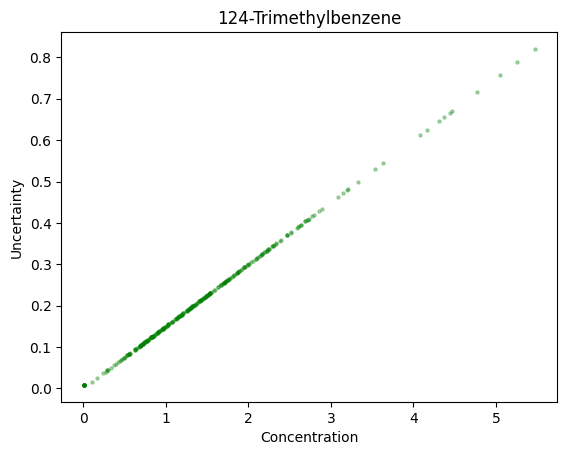

In [4]:
# Scatter plot concentration vs uncertainty
import warnings
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

species = "124-Trimethylbenzene"

concentration_data = dh.input_data[species]
uncertainty_data = dh.uncertainty_data[species]
plt.scatter(x=concentration_data, y=uncertainty_data, s=5, c='green', alpha=0.3)
plt.title(f"{species}")
plt.xlabel("Concentration")
plt.ylabel("Uncertainty")
plt.show()

In [5]:
# Base model paramters

n_components = 4            # number of factors
method1 = "mu"               # minimization algorithm: 'mu' multiplicative update - Kullback-Leibler, 'euc' multiplicative update - frobenius, 'is' multiplicative update - itakura-saito, 'gd' gradient descent, 'cg' conjugate descent
seed = 42                   # randomization seed
epochs = 10                # number of models to create
max_iterations = 20000      # max number of iterations to run for multiplicative update models
converge_delta = 1       # the amount of change between iterations for a multiplicative model considered converged
converge_n = 100            # the number of iterations required with a loss change of less than converge_delta for the model to be considered converged

V = dh.input_data_processed
U = dh.uncertainty_data_processed

In [6]:
# Kullback-Leibler divergence with weights
# https://www.researchgate.net/publication/221080181_Kullback-Leibler_Divergence_for_Nonnegative_Matrix_Factorization
# https://perso.uclouvain.be/paul.vandooren/publications/BlondelHV07.pdf

base = BaseSearch(n_components=n_components, method=method1, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base.train()

Epoch: 0, Seed: 8925, Best Q(true): 122729.6796875, Q(true): 122763.1171875:   7%| | 1400/20000 [00:04<01:04, 287.19it/
Epoch: 1, Seed: 77395, Best Q(true): 106689.4765625, Q(true): 120246.71875:  56%|▌| 11137/20000 [00:39<00:31, 283.64it/
Epoch: 5, Seed: 85859, Best Q(true): 104531.0234375, Q(true): 119992.9765625:  54%|▌| 10726/20000 [00:36<00:31, 293.40i
Epoch: 8, Seed: 20146, Best Q(true): 107733.296875, Q(true): 120727.1015625:  57%|▌| 11366/20000 [00:40<00:30, 278.65it
Epoch: 9, Seed: 9417, Best Q(true): 122334.703125, Q(true): 122335.15625:   4%|▏  | 858/20000 [00:02<01:06, 287.62it/s]
01-Mar-23 14:21:17 - Results - Best Model: 5, Converged: False, Q: 104531.0234375
01-Mar-23 14:21:17 - Runtime: 4.97 min(s)


In [10]:
save_output_path = f"{method1}-e{epochs}-c{n_components}-br.json"
base.save(output_name=save_output_path)

01-Mar-23 14:23:52 - Results saved to: .\mu-e10-c4-br.json


In [11]:
pmf_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"baton-rouge_{n_components}f_profiles.txt")
pmf_residuals_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"baton-rouge_{n_components}f_residuals.txt")
profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
profile_comparison.compare(PMF_Q=pmf_q)

R2 - Model: 8, Best permutations: ['Factor 4', 'Factor 1', 'Factor 3', 'Factor 2'], Average: 0.9907052811429599, Factors: [0.98153710045852, 0.9994877782401815, 0.983874028396249, 0.9979222174768888]
PMF5 Q(true): 86973.578125, NMF-PY Model 8 Q(true): 107733.296875


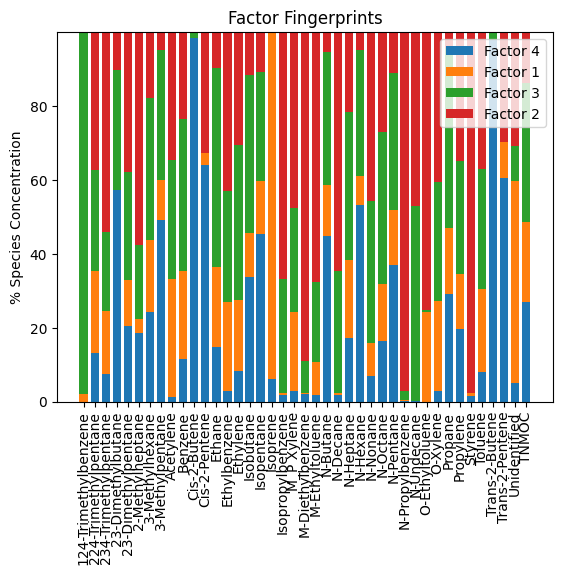

In [12]:
# Fingerprint Profile

warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

totals = np.sum(base.results[base.best_epoch]['H'], axis=0)
scaled_factors = base.results[base.best_epoch]['H'] / totals

width = 0.75
fig, ax = plt.subplots()

plot_bottom = np.zeros(len(dh.features))
label = True

for i, scaled_factor in enumerate(scaled_factors):
    p = ax.bar(dh.features, 100*scaled_factor, width=width, label=profile_comparison.factor_map[i], bottom=plot_bottom)
    plot_bottom += 100*scaled_factor
    
ax.set_title("Factor Fingerprints")
ax.legend(loc="upper right")
plt.ylabel("% Species Concentration")
plt.xticks(rotation=90)
plt.show()

In [13]:
# LS-NMF (weighted frobenius divergence) - available in NMF R package
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1450309/

method2 = "euc"
# max_iterations = 20000
converge_delta = 0.1
# converge_n = 100
base2 = BaseSearch(n_components=n_components, method=method2, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base2.train()

Epoch: 0, Seed: 8925, Best Q(true): 177135.828125, Q(true): 177555.953125:  59%|▌| 11862/20000 [00:45<00:31, 260.20it/s
Epoch: 1, Seed: 77395, Best Q(true): 227233.890625, Q(true): 230722.28125:  53%|▌| 10538/20000 [00:35<00:31, 299.89it/s
Epoch: 2, Seed: 65457, Best Q(true): 176794.375, Q(true): 177671.359375:  53%|█ | 10643/20000 [00:35<00:30, 303.70it/s]
Epoch: 3, Seed: 43887, Best Q(true): 177300.515625, Q(true): 177674.78125:  59%|▌| 11863/20000 [00:42<00:29, 277.26it/s
Epoch: 9, Seed: 9417, Best Q(true): 177321.1875, Q(true): 177697.125:  58%|██▉  | 11628/20000 [00:42<00:30, 271.87it/s]
01-Mar-23 14:31:18 - Results - Best Model: 2, Converged: False, Q: 176794.375
01-Mar-23 14:31:18 - Runtime: 7.31 min(s)


In [14]:
save_output_path = f"{method2}-e{epochs}-c{n_components}-br.json"
base2.save(output_name=save_output_path)
profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
profile_comparison.compare(PMF_Q=pmf_q)

01-Mar-23 14:31:19 - Results saved to: .\euc-e10-c4-br.json


R2 - Model: 2, Best permutations: ['Factor 3', 'Factor 1', 'Factor 2', 'Factor 4'], Average: 0.9493210635595488, Factors: [0.840063423873639, 0.9885758464319254, 0.9855699420045475, 0.9830750419280833]
PMF5 Q(true): 86973.578125, NMF-PY Model 2 Q(true): 176794.375


In [ ]:
# IS https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=4229f467b059188fc7a1234016a3c80557fa7df0